The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-beta0
!pip install "syne-tune[gpsearchers]==0.3.2"


# Asynchronous Successive Halving

:label:`sec_sh_async`

As we have seen in :numref:`sec_rs_async`, we can accelerate HPO by
distributing the evaluation of hyperparameter configurations across either
multiple instances or multiples CPUs / GPUs on a single instance. However,
compared to random search, it is not straightforward to run
successive halving (SH) asynchronously in a distributed setting. Before we can
decide which configuration to run next, we first have to collect all
observations at the current rung level. This requires to
synchronize workers at each rung level. For example, for the lowest rung level
$r_{\mathrm{min}}$, we first have to evaluate all $N = \eta^K$ configurations, before we
can promote the $\frac{1}{\eta}$ of them to the next rung level.

In any distributed system, synchronization typically implies idle time for workers.
First, we often observe high variations in training time across hyperparameter
configurations. For example, assuming the number of filters per layer is a
hyperparameter, then networks with less filters finish training faster than
networks with more filters, which implies idle worker time due to stragglers.
Moreover, the number of slots in a rung level is not always a multiple of the number
of workers, in which case some workers may even sit idle for a full batch.

Figure :numref:`synchronous_sh` shows the scheduling of synchronous SH with $\eta=2$
for four different trials with two workers. We start with evaluating Trial-0 and
Trial-1 for one epoch and immediately continue with the next two trials once they
are finished. We first have to wait until Trial-2 finishes, which takes
substantially more time than the other trials, before we can promote the best two
trials, i.e., Trial-0 and Trial-3 to the next rung level. This causes idle time for
Worker-1. Then, we continue with Rung 1. Also, here Trial-3 takes longer than Trial-0,
which leads to an additional ideling time of Worker-0. Once, we reach Rung-2, only
the best trial, Trial-0, remains which occupies only one worker. To avoid that
Worker-1 idles during that time, most implementaitons of SH continue already with
the next round, and start evaluating new trials (e.g Trial-4) on the first rung.

![Synchronous successive halving with two workers.](http://d2l.ai/_images/sync_sh.svg)
:label:`synchronous_sh`

Asynchronous successive halving (ASHA) :cite:`li-arxiv18` adapts SH to the asynchronous
parallel scenario. The main idea of ASHA is to promote configurations to the next rung
level as soon as we collected at least $\eta$ observations on the current rung level.
This decision rule may lead to suboptimal promotions: configurations can be promoted to the
next rung level, which in hindsight do not compare favourably against most others
at the same rung level. On the other hand, we get rid of all synchronization points
this way. In practice, such suboptimal initial promotions have only a modest impact on
performance, not only because the ranking of hyperparameter configurations is often
fairly consistent across rung levels, but also because rungs grow over time and
reflect the distribution of metric values at this level better and better. If a
worker is free, but no configuration can be promoted, we start a new configuration
with $r = r_{\mathrm{min}}$, i.e the first rung level.

:numref:`asha` shows the scheduling of the same configurations for ASHA. Once Trial-1
finishes, we collect the results of two trials (i.e Trial-0 and Trial-1) and
immediately promote the better of them (Trial-0) to the next rung level. After Trial-0
finishes on rung 1, there are too few trials there in order to support a further
promotion. Hence, we continue with rung 0 and evaluate Trial-3. Once Trial-3 finishes,
Trial-2 is still pending. At this point we have 3 trials evaluated on rung 0 and one
trial evaluated already on rung 1. Since Trial-3 performs worse than Trial-0 at rung 0,
and $\eta=2$, we cannot promote any new trial yet, and Worker-1 starts Trial-4 from
scratch instead. However, once Trial-2 finishes and
scores worse than Trial-3, the latter is promoted towards rung 1. Afterwards, we
collected 2 evaluations on rung 1, which means we can now promote Trial-0 towards
rung 2. At the same time, Worker-1 continues with evaluating new trials (i.e.,
Trial-5) on rung 0.


![Asynchronous successive halving (ASHA) with two workers.](http://d2l.ai/_images/asha.svg)
:label:`asha`


In [1]:
import logging
from d2l import torch as d2l

logging.basicConfig(level=logging.INFO)
import matplotlib.pyplot as plt
from syne_tune import StoppingCriterion, Tuner
from syne_tune.backend.python_backend import PythonBackend
from syne_tune.config_space import loguniform, randint
from syne_tune.experiments import load_experiment
from syne_tune.optimizer.baselines import ASHA

INFO:root:SageMakerBackend is not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[extra]'


AWS dependencies are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[aws]'
or (for everything)
   pip install 'syne-tune[extra]'
AWS dependencies are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[aws]'
or (for everything)
   pip install 'syne-tune[extra]'


INFO:root:Ray Tune schedulers and searchers are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[raytune]'
or (for everything)
   pip install 'syne-tune[extra]'


## Objective Function

We will use *Syne Tune* with the same objective function as in
:numref:`sec_rs_async`.


In [2]:
def hpo_objective_lenet_synetune(learning_rate, batch_size, max_epochs):
    from syne_tune import Reporter
    from d2l import torch as d2l

    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=1, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    report = Reporter()
    for epoch in range(1, max_epochs + 1):
        if epoch == 1:
            # Initialize the state of Trainer
            trainer.fit(model=model, data=data)
        else:
            trainer.fit_epoch()
        validation_error = trainer.validation_error().cpu().detach().numpy()
        report(epoch=epoch, validation_error=float(validation_error))

We will also use the same configuration space as before:


In [3]:
min_number_of_epochs = 2
max_number_of_epochs = 10
eta = 2

config_space = {
    "learning_rate": loguniform(1e-2, 1),
    "batch_size": randint(32, 256),
    "max_epochs": max_number_of_epochs,
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

## Asynchronous Scheduler

First, we define the number of workers that evaluate trials concurrently. We
also need to specify how long we want to run random search, by defining an
upper limit on the total wall-clock time.


In [4]:
n_workers = 2  # Needs to be <= the number of available GPUs
max_wallclock_time = 12 * 60  # 12 minutes

The code for running ASHA is a simple variation of what we did for asynchronous
random search.


In [5]:
mode = "min"
metric = "validation_error"
resource_attr = "epoch"

scheduler = ASHA(
    config_space,
    metric=metric,
    mode=mode,
    points_to_evaluate=[initial_config],
    max_resource_attr="max_epochs",
    resource_attr=resource_attr,
    grace_period=min_number_of_epochs,
    reduction_factor=eta,
)

INFO:syne_tune.optimizer.schedulers.fifo:max_resource_level = 10, as inferred from config_space


INFO:syne_tune.optimizer.schedulers.fifo:Master random_seed = 2519082400


Here, `metric` and `resource_attr` specify the key names used with the `report`
callback, and `max_resource_attr` denotes which input to the objective function
corresponds to $r_{\mathrm{max}}$. Moreover, `grace_period` provides $r_{\mathrm{min}}$, and
`reduction_factor` is $\eta$. We can run Syne Tune as before (this will
take about 12 minutes):


In [6]:
trial_backend = PythonBackend(
    tune_function=hpo_objective_lenet_synetune,
    config_space=config_space,
)

stop_criterion = StoppingCriterion(max_wallclock_time=max_wallclock_time)
tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
    print_update_interval=int(max_wallclock_time * 0.6),
)
tuner.run()

INFO:syne_tune.tuner:results of trials will be saved on /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569


INFO:root:Detected 4 GPUs


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.1 --batch_size 128 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/0/checkpoints


INFO:syne_tune.tuner:(trial 0) - scheduled config {'learning_rate': 0.1, 'batch_size': 128, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.26026414576354656 --batch_size 190 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/1/checkpoints


INFO:syne_tune.tuner:(trial 1) - scheduled config {'learning_rate': 0.26026414576354656, 'batch_size': 190, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.2593604522804441 --batch_size 175 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/2/checkpoints


INFO:syne_tune.tuner:(trial 2) - scheduled config {'learning_rate': 0.2593604522804441, 'batch_size': 175, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.05839172893509113 --batch_size 121 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/3/checkpoints


INFO:syne_tune.tuner:(trial 3) - scheduled config {'learning_rate': 0.05839172893509113, 'batch_size': 121, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 1 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.03929792833045943 --batch_size 74 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/4/checkpoints


INFO:syne_tune.tuner:(trial 4) - scheduled config {'learning_rate': 0.03929792833045943, 'batch_size': 74, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.017114910518484957 --batch_size 118 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/5/checkpoints


INFO:syne_tune.tuner:(trial 5) - scheduled config {'learning_rate': 0.017114910518484957, 'batch_size': 118, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.37032436577012906 --batch_size 180 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/6/checkpoints


INFO:syne_tune.tuner:(trial 6) - scheduled config {'learning_rate': 0.37032436577012906, 'batch_size': 180, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.7056638124371359 --batch_size 135 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/7/checkpoints


INFO:syne_tune.tuner:(trial 7) - scheduled config {'learning_rate': 0.7056638124371359, 'batch_size': 135, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.020532957281712227 --batch_size 245 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/8/checkpoints


INFO:syne_tune.tuner:(trial 8) - scheduled config {'learning_rate': 0.020532957281712227, 'batch_size': 245, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.0629178212109721 --batch_size 122 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/9/checkpoints


INFO:syne_tune.tuner:(trial 9) - scheduled config {'learning_rate': 0.0629178212109721, 'batch_size': 122, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.019719167343159 --batch_size 201 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/10/checkpoints


INFO:syne_tune.tuner:(trial 10) - scheduled config {'learning_rate': 0.019719167343159, 'batch_size': 201, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.05304341062541745 --batch_size 173 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/11/checkpoints


INFO:syne_tune.tuner:(trial 11) - scheduled config {'learning_rate': 0.05304341062541745, 'batch_size': 173, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.021165246091620914 --batch_size 111 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/12/checkpoints


INFO:syne_tune.tuner:(trial 12) - scheduled config {'learning_rate': 0.021165246091620914, 'batch_size': 111, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.022367147396573767 --batch_size 94 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/13/checkpoints


INFO:syne_tune.tuner:(trial 13) - scheduled config {'learning_rate': 0.022367147396573767, 'batch_size': 94, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.7090001921320975 --batch_size 131 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/14/checkpoints


INFO:syne_tune.tuner:(trial 14) - scheduled config {'learning_rate': 0.7090001921320975, 'batch_size': 131, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.28789831336049837 --batch_size 223 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/15/checkpoints


INFO:syne_tune.tuner:(trial 15) - scheduled config {'learning_rate': 0.28789831336049837, 'batch_size': 223, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.010275737694227193 --batch_size 253 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/16/checkpoints


INFO:syne_tune.tuner:(trial 16) - scheduled config {'learning_rate': 0.010275737694227193, 'batch_size': 253, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.035810261826711376 --batch_size 78 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/17/checkpoints


INFO:syne_tune.tuner:(trial 17) - scheduled config {'learning_rate': 0.035810261826711376, 'batch_size': 78, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.991770631068777 --batch_size 177 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/18/checkpoints


INFO:syne_tune.tuner:(trial 18) - scheduled config {'learning_rate': 0.991770631068777, 'batch_size': 177, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.19353908485783836 --batch_size 175 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/19/checkpoints


INFO:syne_tune.tuner:(trial 19) - scheduled config {'learning_rate': 0.19353908485783836, 'batch_size': 175, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.13767814903984632 --batch_size 113 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/20/checkpoints


INFO:syne_tune.tuner:(trial 20) - scheduled config {'learning_rate': 0.13767814903984632, 'batch_size': 113, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 19 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.06689780910032862 --batch_size 206 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/21/checkpoints


INFO:syne_tune.tuner:(trial 21) - scheduled config {'learning_rate': 0.06689780910032862, 'batch_size': 206, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.019275389510134598 --batch_size 109 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/22/checkpoints


INFO:syne_tune.tuner:(trial 22) - scheduled config {'learning_rate': 0.019275389510134598, 'batch_size': 109, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.13679721709095005 --batch_size 204 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/23/checkpoints


INFO:syne_tune.tuner:(trial 23) - scheduled config {'learning_rate': 0.13679721709095005, 'batch_size': 204, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 20 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.010107005780258107 --batch_size 84 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/24/checkpoints


INFO:syne_tune.tuner:(trial 24) - scheduled config {'learning_rate': 0.010107005780258107, 'batch_size': 84, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.07973486182653855 --batch_size 164 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/25/checkpoints


INFO:syne_tune.tuner:(trial 25) - scheduled config {'learning_rate': 0.07973486182653855, 'batch_size': 164, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.01862028762163817 --batch_size 224 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/26/checkpoints


INFO:syne_tune.tuner:(trial 26) - scheduled config {'learning_rate': 0.01862028762163817, 'batch_size': 224, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.036123512065712356 --batch_size 145 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/27/checkpoints


INFO:syne_tune.tuner:(trial 27) - scheduled config {'learning_rate': 0.036123512065712356, 'batch_size': 145, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.23270803627508607 --batch_size 142 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/28/checkpoints


INFO:syne_tune.tuner:(trial 28) - scheduled config {'learning_rate': 0.23270803627508607, 'batch_size': 142, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.2175164329242562 --batch_size 214 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/29/checkpoints


INFO:syne_tune.tuner:(trial 29) - scheduled config {'learning_rate': 0.2175164329242562, 'batch_size': 214, 'max_epochs': 10}


INFO:syne_tune.tuner:tuning status (last metric is reported)
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        0    Stopped     2       0.100000         128          10      2          0.900415    13.006364
        1  Completed    10       0.260264         190          10     10          0.228517    63.734704
        2    Stopped     4       0.259360         175          10      4          0.395764    24.291798
        3    Stopped     2       0.058392         121          10      2          0.900154    13.496355
        4    Stopped     2       0.039298          74          10      2          0.900000    13.699395
        5    Stopped     4       0.017115         118          10      4          0.899857    23.707576
        6    Stopped     4       0.370324         180          10      4          0.440397    22.239016
        7    Stopped    10       0.705664         135          10     10          0.178716    61.475051
   

INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.05620144765208902 --batch_size 178 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/30/checkpoints


INFO:syne_tune.tuner:(trial 30) - scheduled config {'learning_rate': 0.05620144765208902, 'batch_size': 178, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.13183451753187736 --batch_size 138 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/31/checkpoints


INFO:syne_tune.tuner:(trial 31) - scheduled config {'learning_rate': 0.13183451753187736, 'batch_size': 138, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.38648751673718523 --batch_size 140 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/32/checkpoints


INFO:syne_tune.tuner:(trial 32) - scheduled config {'learning_rate': 0.38648751673718523, 'batch_size': 140, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.08056220664175624 --batch_size 67 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/33/checkpoints


INFO:syne_tune.tuner:(trial 33) - scheduled config {'learning_rate': 0.08056220664175624, 'batch_size': 67, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 32 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.3324276291831479 --batch_size 46 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/34/checkpoints


INFO:syne_tune.tuner:(trial 34) - scheduled config {'learning_rate': 0.3324276291831479, 'batch_size': 46, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 33 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.052248666156177404 --batch_size 98 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/35/checkpoints


INFO:syne_tune.tuner:(trial 35) - scheduled config {'learning_rate': 0.052248666156177404, 'batch_size': 98, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.9830549238437887 --batch_size 79 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/36/checkpoints


INFO:syne_tune.tuner:(trial 36) - scheduled config {'learning_rate': 0.9830549238437887, 'batch_size': 79, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 34 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.032557880666396095 --batch_size 93 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/37/checkpoints


INFO:syne_tune.tuner:(trial 37) - scheduled config {'learning_rate': 0.032557880666396095, 'batch_size': 93, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 36 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.4064583027576585 --batch_size 158 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/38/checkpoints


INFO:syne_tune.tuner:(trial 38) - scheduled config {'learning_rate': 0.4064583027576585, 'batch_size': 158, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.2772223521231802 --batch_size 233 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/39/checkpoints


INFO:syne_tune.tuner:(trial 39) - scheduled config {'learning_rate': 0.2772223521231802, 'batch_size': 233, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 38 completed.


INFO:syne_tune.tuner:Trial trial_id 39 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.10873119678527206 --batch_size 248 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/40/checkpoints


INFO:syne_tune.tuner:(trial 40) - scheduled config {'learning_rate': 0.10873119678527206, 'batch_size': 248, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.040718891224091586 --batch_size 203 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/41/checkpoints


INFO:syne_tune.tuner:(trial 41) - scheduled config {'learning_rate': 0.040718891224091586, 'batch_size': 203, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.021227650192938544 --batch_size 219 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/42/checkpoints


INFO:syne_tune.tuner:(trial 42) - scheduled config {'learning_rate': 0.021227650192938544, 'batch_size': 219, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.09154807893415777 --batch_size 219 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/tune_function --tune_function_hash 9cdb4b30531006fc01c82e2f69e476b4 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569/43/checkpoints


INFO:syne_tune.tuner:(trial 43) - scheduled config {'learning_rate': 0.09154807893415777, 'batch_size': 219, 'max_epochs': 10}


INFO:syne_tune.stopping_criterion:reaching max wallclock time (720), stopping there.


INFO:syne_tune.tuner:Stopping trials that may still be running.


INFO:syne_tune.tuner:Tuning finished, results of trials can be found on /home/ci/syne-tune/python-entrypoint-2023-08-14-17-12-17-569


--------------------
Resource summary (last result is reported):
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        0    Stopped     2       0.100000         128          10    2.0          0.900415    13.006364
        1  Completed    10       0.260264         190          10   10.0          0.228517    63.734704
        2    Stopped     4       0.259360         175          10    4.0          0.395764    24.291798
        3    Stopped     2       0.058392         121          10    2.0          0.900154    13.496355
        4    Stopped     2       0.039298          74          10    2.0          0.900000    13.699395
        5    Stopped     4       0.017115         118          10    4.0          0.899857    23.707576
        6    Stopped     4       0.370324         180          10    4.0          0.440397    22.239016
        7    Stopped    10       0.705664         135          10   10.0          0.178716    61.475051

Note that we are running a variant of ASHA where underperforming trials are
stopped early. This is different to our implementation in
:numref:`sec_mf_hpo_sh`, where each training job is started with a fixed
`max_epochs`. In the latter case, a well-performing trial which reaches the
full 10 epochs, first needs to train 1, then 2, then 4, then 8 epochs, each
time starting from scratch. This type of pause-and-resume scheduling can be
implemented efficiently by checkpointing the training state after each epoch,
but we avoid this extra complexity here. After the experiment has finished,
we can retrieve and plot results.


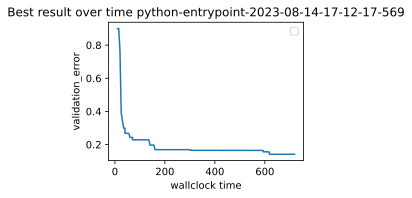

In [7]:
d2l.set_figsize()
e = load_experiment(tuner.name)
e.plot()

## Visualize the Optimization Process

Once more, we visualize the learning curves of every trial (each color in the plot represents a trial). Compare this to
asynchronous random search in :numref:`sec_rs_async`. As we have seen for
successive halving in :numref:`sec_mf_hpo`, most of the trials are stopped
at 1 or 2 epochs ($r_{\mathrm{min}}$ or $\eta * r_{\mathrm{min}}$). However, trials do not stop
at the same point, because they require different amount of time per epoch. If
we ran standard successive halving instead of ASHA, we would need to synchronize
our workers, before we can promote configurations to the next rung level.


Text(0, 0.5, 'objective function')

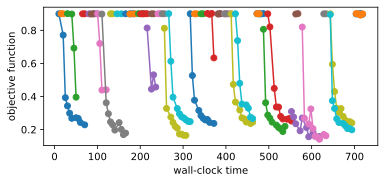

In [8]:
d2l.set_figsize([6, 2.5])
results = e.results
for trial_id in results.trial_id.unique():
    df = results[results["trial_id"] == trial_id]
    d2l.plt.plot(
        df["st_tuner_time"],
        df["validation_error"],
        marker="o"
    )
d2l.plt.xlabel("wall-clock time")
d2l.plt.ylabel("objective function")

## Summary

Compared to random search, successive halving is not quite as trivial to run in
an asynchronous distributed setting. To avoid synchronisation points, we promote
configurations as quickly as possible to the next rung level, even if this means
promoting some wrong ones. In practice, this usually does not hurt much, and the
gains of asynchronous versus synchronous scheduling are usually much higher
than the loss of the suboptimal decision making.


[Discussions](https://discuss.d2l.ai/t/12101)
